# notes on fitting

I'm building a velocity-depth trend and I need the resulting trendline to be anchored to the velocity aorund the sea bottom, otherwise I may end up with some crazy ass trends.

I have found a solution on [stackexchange](http://stackoverflow.com/questions/15191088/how-to-do-a-polynomial-fit-with-fixed-points) but I wonder if there's anything simpler (and that I may be able to actually understand).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
# comment out the following if you're not on a Mac with HiDPI display
%config InlineBackend.figure_format = 'retina'

This is the function that does the magic (taken from 
<http://stackoverflow.com/questions/15191088/how-to-do-a-polynomial-fit-with-fixed-points>):

In [3]:
def solve_ns(A, b): return np.linalg.solve(np.dot(A.T, A), np.dot(A.T, b))
def clsq(A, b, C, d):
    """An 'exact' constrained least squared solution of Ax= b, s.t. Cx= d"""
    from scipy.linalg import qr
    p= C.shape[0]
    Q, R= qr(C.T)
    xr, AQ= np.linalg.solve(R[:p].T, d), np.dot(A, Q)
    xaq= solve_ns(AQ[:, p:], b- np.dot(AQ[:, :p], xr))
    return np.dot(Q[:, :p], xr)+ np.dot(Q[:, p:], xaq)
def cpf(x, y, x_c, y_c, n):
    """Constrained polynomial fit based on clsq solution."""
    from numpy.polynomial.polynomial import Polynomial as P, polyvander as V
    x_c = np.array([x_c])
    y_c = np.array([y_c])
    return P(clsq(V(x, n), y, V(x_c, n), y_c))

An example on how to use it.

Let's pretend that the water depth is 200m and that the velocity of the first meters of sediments is 1600 m/s. This pair of points will be our 'anchor'.

In [11]:
L=pd.read_csv('qsiwell2.csv')

vp=L.VP.values
z=L.DEPTH.values
mask = np.isfinite(vp) # mask to select valid (i.e., not NaNs) velocity samples

# anchor points
z0=1000
vp0=1600
vs0=800
rho0=1.5

# final trends will be calculated over zfit that goes from z0=seabottom to 3000m
zfit = np.linspace(z0,3000,100)

# simple linear fit
fit0 = np.polyfit(z[mask],vp[mask],1)
trend0 = np.polyval(fit0,zfit)

# constrained polynomial fit
p = cpf(z[mask], vp[mask], z0 , vp0, 1)
trend1 = p(zfit)

Plots the velocity log with the two trendlines and the anchor point at the seabottom:

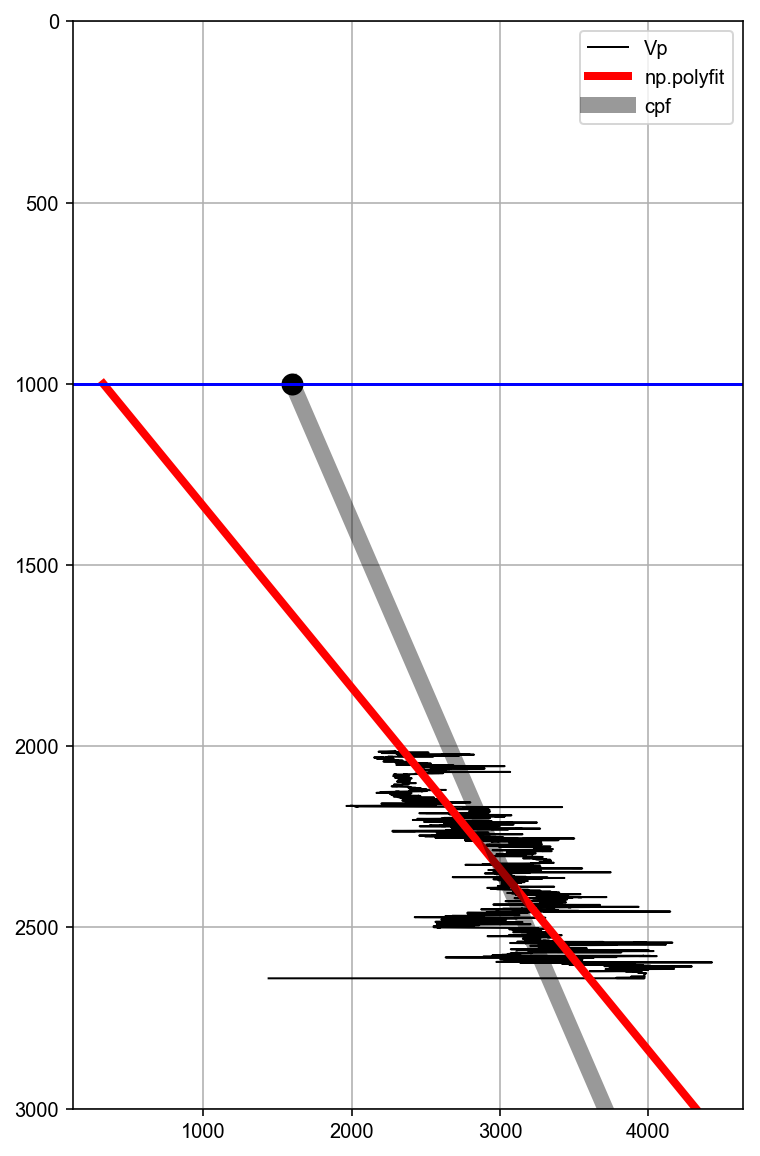

In [30]:
plt.figure(figsize=(6,10))
plt.plot(vp,z,'k',lw=1,label='Vp')
plt.plot(trend0,zfit,'r',lw=4,label='np.polyfit')
plt.plot(trend1,zfit,'k',alpha=0.4,lw=8,label='cpf')
plt.plot(vp0,z0,'ko',ms=10)
plt.ylim(3000,0)
plt.axhline(y=z0, color='b')
plt.legend()
plt.grid()

# solutions and further doubts

Alright, so today (8th February 2017, the notes above were written yesterday) I managed to solve all the problems related to calculations and Python/Numpy functions to use. But there's still things that are not very clear to me, let me show what are the remaining doubts.

### alternative/easier solution for constrained linear fit

Basically instead of the overly complicated `cpf` function above which I don't even understand, is there another way to constrain a linear fit to cross certain points?

...well there is:

In [22]:
# constrained linear fit
m = np.linalg.lstsq(z[mask][:,None]-z0,vp[mask][:,None]-vp0)[0]
trend2 = m.flatten()*(zfit-z0)+vp0

So `trend2` (yellow thin line below) gives exactly the same result as `cpf` (when `cpf` is run with degree=1):

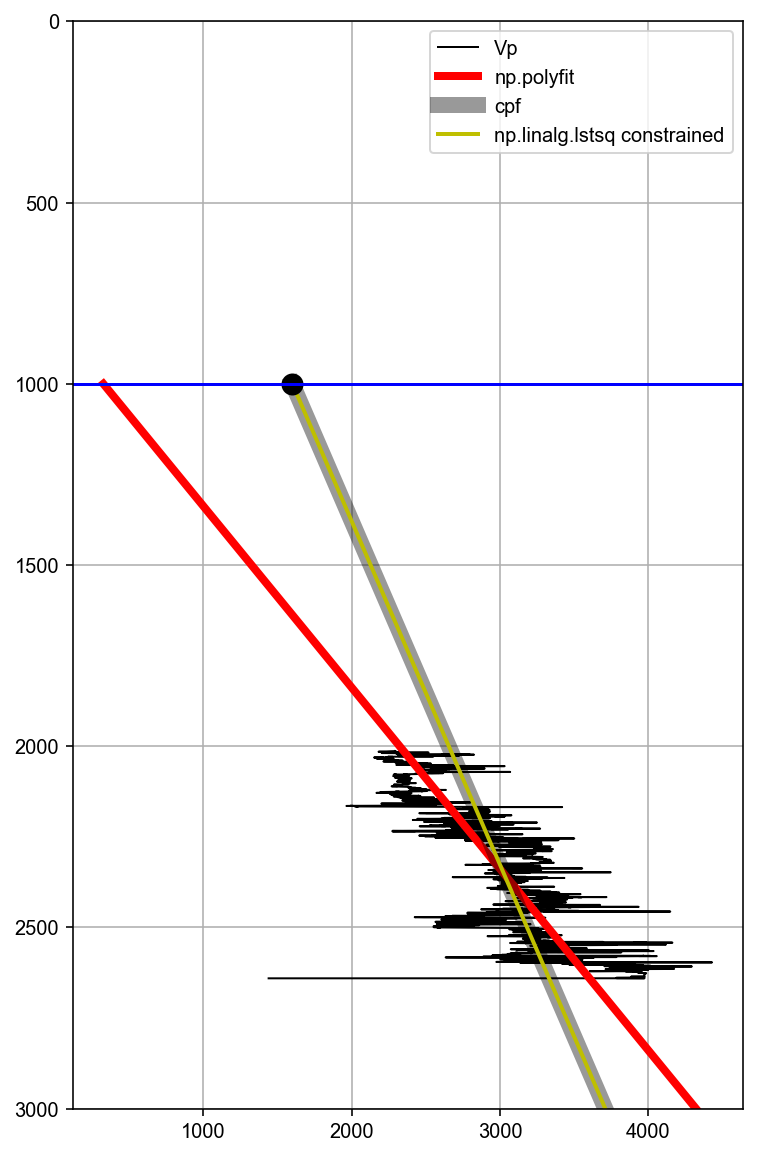

In [28]:
plt.figure(figsize=(6,10))
plt.plot(vp,z,'k',lw=1,label='Vp')
plt.plot(trend0,zfit,'r',lw=4,label='np.polyfit')
plt.plot(trend1,zfit,'k',alpha=0.4,lw=8,label='cpf')
plt.plot(trend2,zfit,'y',lw=2,label='np.linalg.lstsq constrained')
plt.plot(vp0,z0,'ko',ms=10)
plt.ylim(3000,0)
plt.axhline(y=z0, color='b')
plt.legend(fontsize='medium')
plt.grid()

### non-linear trends

The elastic properties depth trends are almost certainly non-linear in real life; linear is a nice and easy approximation but almost certainly not true.

I can use `curve_fit` using arbitrary functions and modify the `sigma` vector to give more weight to a certain datapoint, so making sure that the fitted function crosses this datapoint (or at least is as close as possible).

In [113]:
from scipy.optimize import curve_fit

def fpow(x, a, b):
    return a * np.power(x,b)

def fexp0(x, b):
    return np.exp(-x/b)

def fexp1(x, a, b):
    return a * np.exp(-x/b)

def fexp2(x, a, b):
    return a * np.exp(-x*b)

In [120]:
# constrained polynomial fit 2nd degree
p = cpf(z[mask], vp[mask], z0 , vp0, 2)
trend3 = p(zfit)

# curve_fit of function a*x**b
p, _ = curve_fit(fpow, z[mask], vp[mask])
trend4 = fpow(zfit, *p)

# curve_fit of function exp(-z/z0)
p, _ = curve_fit(fexp0, z[mask], vp[mask], p0=(2000))
trend5 = fexp0(zfit, *p)
print('fexp0: np.exp(-x/x0) --> {}'.format(p))

# curve_fit of function a*exp(-z/z0)
p, _ = curve_fit(fexp1, z[mask], vp[mask], p0=(500,0.0001))
trend6 = fexp1(zfit, *p)
print('fexp1: a*np.exp(-x/xo) --> {}'.format(p))

# curve_fit of function a*exp(-z*b)
p, _ = curve_fit(fexp2, z[mask], vp[mask], p0=(500,1000))
trend7 = fexp2(zfit, *p)
print('fexp2: a*np.exp(-x*b) --> {}'.format(p))

fexp0: np.exp(-x/x0) --> [ 54401908.77729815]
fexp1: a*np.exp(-x/xo) --> [  5.00000000e+02   1.00000000e-04]
fexp2: a*np.exp(-x*b) --> [  500.  1000.]


/Users/aadm/miniconda2/envs/snakes/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


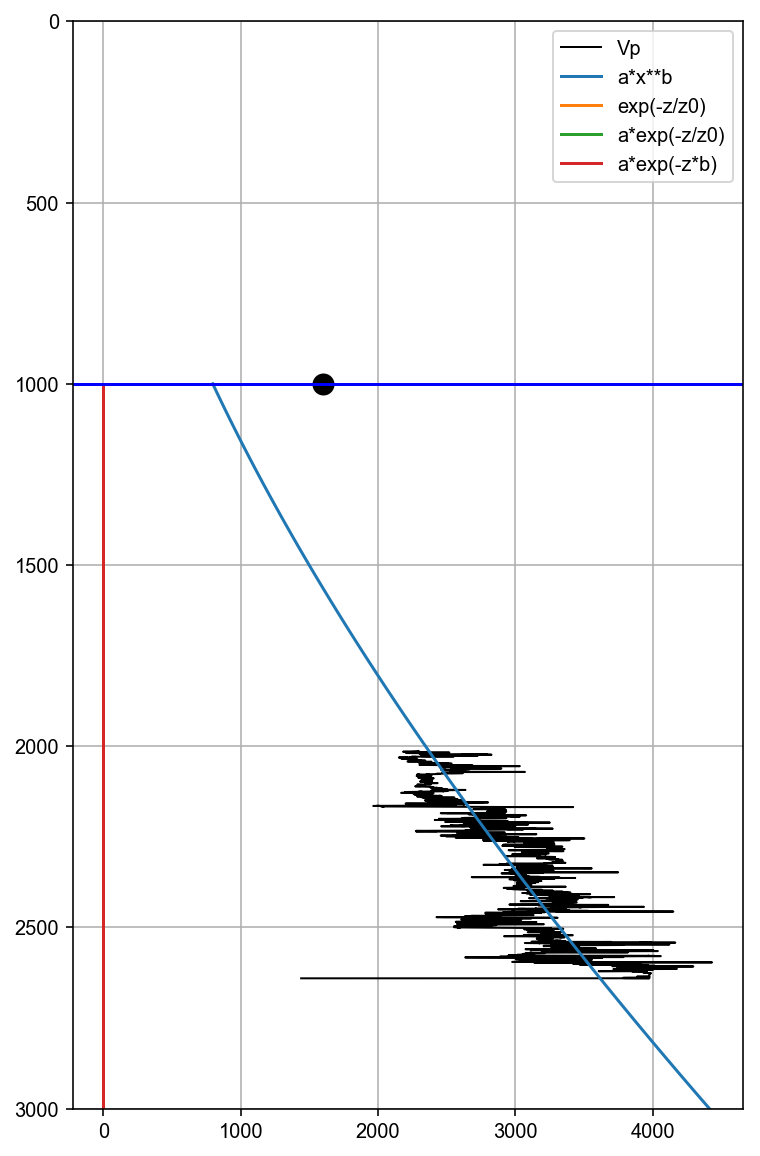

In [122]:
plt.figure(figsize=(6,10))
plt.plot(vp,z,'k',lw=1,label='Vp')
# plt.plot(trend0,zfit,'r',lw=4,label='np.polyfit')
# plt.plot(trend2,zfit,'y',lw=2,label='np.linalg.lstsq constrained')
plt.plot(trend4,zfit,label='a*x**b')
plt.plot(trend5,zfit,label='exp(-z/z0)')
plt.plot(trend6,zfit,label='a*exp(-z/z0)')
plt.plot(trend7,zfit,label='a*exp(-z*b)')
plt.plot(vp0,z0,'ko',ms=10)
plt.ylim(3000,0)
plt.axhline(y=z0, color='b')
plt.legend(fontsize='medium')
plt.grid()

In [124]:
# to constrain curve_fit first I add the anchor point to the top of the log
# then create a sigma vector with a absurdly low value (=high weight)
# corresponding to this first point 
z1=np.insert(z[mask],0,z0)
vp1=np.insert(vp[mask],0,vp0)
sigma =np.ones(z1.size)
sigma[0] = 0.0001


# curve_fit of function a*x**b
p, _ = curve_fit(fpow, z1, vp1, sigma=sigma)
trend4a = fpow(zfit, *p)

# curve_fit of function exp(-z/z0)
p, _ = curve_fit(fexp0, z1, vp1, sigma=sigma, p0=(2000))
trend5a = fexp0(zfit, *p)
print('fexp0: np.exp(-x/x0) --> {}'.format(p))

# curve_fit of function a*exp(-z/z0)
p, _ = curve_fit(fexp1, z1, vp1, sigma=sigma, p0=(500,0.0001))
trend6a = fexp1(zfit, *p)
print('fexp1: a*np.exp(-x/xo) --> {}'.format(p))

# curve_fit of function a*exp(-z*b)
p, _ = curve_fit(fexp2, z1, vp1, sigma=sigma, p0=(500,1000))
trend7a = fexp2(zfit, *p)
print('fexp2: a*np.exp(-x*b) --> {}'.format(p))

fexp0: np.exp(-x/x0) --> [ 64201926.41216222]
fexp1: a*np.exp(-x/xo) --> [  5.00000000e+02   1.00000000e-04]
fexp2: a*np.exp(-x*b) --> [  500.  1000.]


/Users/aadm/miniconda2/envs/snakes/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


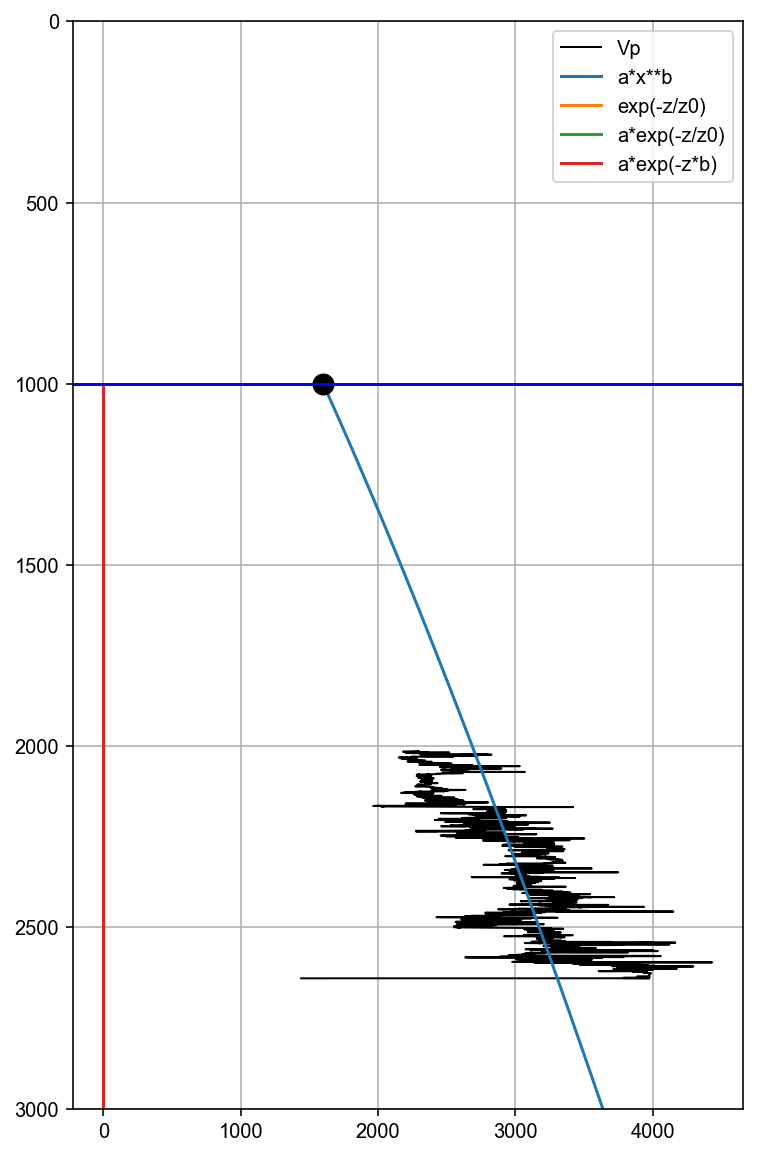

In [126]:
plt.figure(figsize=(6,10))
plt.plot(vp,z,'k',lw=1,label='Vp')
# plt.plot(trend0,zfit,'r',lw=4,label='np.polyfit')
# plt.plot(trend2,zfit,'y',lw=2,label='np.linalg.lstsq constrained')
plt.plot(trend4a,zfit,label='a*x**b')
plt.plot(trend5a,zfit,label='exp(-z/z0)')
plt.plot(trend6a,zfit,label='a*exp(-z/z0)')
plt.plot(trend7a,zfit,label='a*exp(-z*b)')
plt.plot(vp0,z0,'ko',ms=10)
plt.ylim(3000,0)
plt.axhline(y=z0, color='b')
plt.legend(fontsize='medium')
plt.grid()

### trends for sands with different fluid fill